# RANSAC sphere fitting

The most difficult part of RANSAC is to create a model needed for fitting. Let us start with this step now.

## Model creation

### Model based on 4 points

First let us fit a sphere to 4 points $P_i(x_i,y_i,z_i)$ with known positions with an algebraic method. This problem has a unique solution for 4 points $i=1,...,4$ since it leads to a linear system of equations with a unique solution (see Paláncz, Molnár (2012) [Wolfram Library Archive](http://library.wolfram.com/infocenter/MathSource/8491/)).

Sphere with radius $R$ fits each point:
$$ \sqrt{(x_i-x_0)^2+(y_i-y_0)^2+(z_i-z_0)^2} -R = 0 $$

hence for each point
$$ \sqrt{(x_i-x_0)^2+(y_i-y_0)^2+(z_i-z_0)^2} +R = 2R = c $$

and the two equations are multiplied that yields
$$ (x_i-x_0)^2+(y_i-y_0)^2+(z_i-z_0)^2 -R^2 = 0 $$

If we introduce a new variable $\alpha$ instead of $R$ the following *linear* system need to be solved for parameters $\mathbf{p}=[x_0, y_0, z_0, \alpha]$
$$ x_i^2 + y_i^2 + z_i^2 -2x_0 x_i -2y_0 y_i - 2z_0 z_i + \alpha = 0$$
where
$$ \alpha = x_0^2 + y_0^2 + z_0^2 -R^2$$

This solution was implemented in the following Python function:


In [1]:
def sph4model(X):
    """
    sph4model(X) fits a sphere to four points given by rows of matrix X
    Reference: Paláncz, Molnár (2012): Fitting sphere to quantized depth information
    Input:  X: 4x3 matrix, coordinates [x,y,z] of points stored as its rows
    Output: a vector [x0, y0, z0, r] with four elements, where:
              r: radius of sphere
              x0, y0, z0: coordinates of the centre of sphere
    Remark:  If there is no solution (given 4 points lie approximately in a plane) then
                 function returns None
    """

    # subtract mean
    Xm = np.mean(X,axis=0)
    Xs = X-Xm

    # matrix M
    M=np.hstack((-2.0*Xs,np.ones((4,1))))
    # vector h
    h=-np.sum(Xs**2,axis=1)  # row sums
    # check condition number of M:
    if np.linalg.cond(M) > 1000:
        return None
    # check determinant:
    if np.abs(np.linalg.det(M)) < 1.0e-15:
        return None
    p=np.linalg.solve(M,h)
    # radius of sphere
    r=np.sqrt(np.sum(p[0:3]**2)-p[3])
    # centre coordinates
    c=p[0:3]+Xm
    return np.hstack((c,r))


Check this function!

In [2]:
import numpy as np

X = np.array([[0.655416348349, 0.200995185452, 0.893622387647], 
              [0.281886543129, 0.525000382971, 0.314126774995], 
              [0.444615678299, 0.299474455628, 0.282689857776], 
              [0.883227485267, 0.270905975731, 0.704419015849]])

p = sph4model(X)
print(p)

[0.54748534 0.49907036 0.62914037 0.41285427]


### Least squares fit to more than 4 points

Least squares method can be used to fit a sphere to more than 4 points. This procedure is implemented in the following Python functions.

In [3]:
def svdsolve(a,b):
    u,s,v = np.linalg.svd(a)
    c = np.dot(u.T,b)
    w = np.divide(c[:len(s)],s)
    x = np.dot(v.T,w)
    return x

def sph4fit(X):
    """
    sph4model(X) fits a sphere to four or more points given by rows of matrix X
    Reference: Paláncz, Molnár (2012): Fitting sphere to quantized depth information
    Input:  X: nx3 matrix, coordinates [x,y,z] of n points stored as its rows
    Output: a vector [x0, y0, z0, r] with four elements, where:
              r: radius of sphere
              x0, y0, z0: coordinates of the centre of sphere
    Remark:  If there is no good solution then this function returns None
    """

    # subtract mean
    Xm = np.mean(X,axis=0)
    Xs = X-Xm
    n = Xs.shape[0]

    # matrix M
    M=np.hstack((-2.0*Xs,np.ones((n,1))))
    # vector h
    h=-np.sum(Xs**2,axis=1)  # sum rows
    # check condition number of M:
    if np.linalg.cond(M) > 1000:
        return None
    p=svdsolve(M,h)
    # radius of sphere
    r=np.sqrt(np.sum(p[0:3]**2)-p[3])
    # centre coordinates
    c=p[0:3]+Xm
    return np.hstack((c,r))

Check this function also:

In [4]:
# 10 points
Xp = np.array([[0.236419323876, 0.94539908057,  0.448603985892], 
               [0.132256383655, 0.0585420373716,0.189678073452], 
               [0.777527902317, 0.237423931798, 0.978964303253], 
               [0.0367820896797,0.191109494886, 0.64247854129 ],
               [0.233535838244, 0.0910807008584,0.899334281424], 
               [0.983635710836, 0.211019679874, 0.552776867983], 
               [0.494141778444, 0.579783629292, 0.811875091404], 
               [0.983877207446, 0.262955546077, 0.993804390297], 
               [0.901832244664, 0.240795911508, 0.635966928702], 
               [0.151086132434, 0.251504104295, 0.33397148847 ]])

p10 = sph4fit(Xp)
print(p10)

[0.50949211 0.39356424 0.54173242 0.5305028 ]


To see the fit, let us calculate (signed or unsigned) deviations from the surface of the sphere using the following function:

In [5]:
def sphdist(sph,X,pos=1):
    """
    sphdist(sph,X) calculate distances of points X from sphere sph
    sph: 4-element vector: [x0, y0, z0, r]
         x0, y0, z0: centre of sphere
         r: radius of sphere
         X: (n,3) matrix, coordinates of n points
       pos: if pos=0 calculate signed, otherwise unsigned deviations
    """
    r = sph[3]
    c = sph[0:3]
    # distance from centre squared
    dc = np.sum((X-c)**2,axis=1)
    if pos==1:
        dist = np.abs(np.sqrt(dc)-r)
    else:
        dist = np.sqrt(dc)-r
    return dist

Residuals of the 4-point fit at the points:

In [6]:
print(sphdist(p,X))

[0.00000000e+00 5.55111512e-17 5.55111512e-17 0.00000000e+00]


The same for 10-point fit:

In [7]:
print(sphdist(p10,Xp))

[0.09220366 0.08471174 0.00558926 0.00648709 0.01312137 0.02231322
 0.20203613 0.13768049 0.09905282 0.09255243]


When there are more outliers, least squares fit is not satisfactory. We use RANSAC instead (Fischler M A, Bolles R C, Random Sample Consensus: A paradigm for model fitting with applications to image analysis and automated cartography, Communications of the ACM, 24(6): 381-395, 1981, [PDF](http://www.cs.ait.ac.th/~mdailey/cvreadings/Fischler-RANSAC.pdf).

Until now we considered modeling and solution of the sphere fitting problem by least squares. In practice, however, our data often contain a large percent of outliers. Fischler and Bolles introduced in their 1981 paper an excellent method of parameter estimation from such data that can advantageously be applied for the present problem.

As we have seen in the [ellipse fitting problem](https://nbviewer.jupyter.org/github/gyulat/Korszeru_matek/blob/master/RANSAC_en.ipynb), RANSAC consists of the following steps:

1. Generate a prescibed number of models (hypotheses) $M$, each from a minimum number $n$ of data necessary for the unique creation of a model (determination of model parameters) 
2. Evaluate each model (hypothesis):
   * calculate deviations of data with respect to the model
   * data with deviations under a specified threshold are considered conform to the model (elements of the consensus set) 
3. Select the model with maximum number of elements of its consensus set (original RANSAC)

The following algorithms (functions) are required for computing with RANSAC:
* model creation using a minimum number $n$ of data
* calculation of fit residuals with respect to a particular model

These functions have already been implemented for the sphere fitting problem, therefore we only need to integrate them into the [ransac](http://scikit-image.org/docs/stable/api/skimage.measure.html?highlight=ransac#skimage.measure.ransac) function of the  [scikit-image](http://scikit-image.org/) library.

Description of the function 
```python
sm.ransac(data, model_class, min_samples, residual_threshold) 
```
tells us that it has got four required parameters. 
1. data matrix `data(N, D)` where `N` denotes the number and `D` is dimension of data,
2. Python implementation of the class with required member functions `success = estimate(*data)` and `residuals(*data)`,
3. integer `min_samples`, which is the same as $n$.
4. `residual_threshold`, maximum distance (residual) of conform data.

### SphereModel Python class

In our case the requred class `SphereModel` for RANSAC contains a simple constructor and two member functions. Member functions require also code of the `svdsolve` function. Member variable `params` stores various parameters (centre and radius) of the best fitting sphere.

In [8]:
class SphereModel:
    """sphere fitting model 
    """

    def __init__(self):
        self.params = np.zeros(4)

    def estimate(self, X):
        """
        estimate(X) fits a sphere to four or more points given by rows of matrix X
        Reference: Paláncz, Molnár (2012): Fitting sphere to quantized depth information
        Input:  X: nx3 matrix, coordinates [x,y,z] of n points stored as its rows
        Output: a vector [x0, y0, z0, r] with four elements, where:
                r: radius of sphere
                x0, y0, z0: coordinates of the centre of sphere
        Remark:  If there is no good solution then this function returns None
        """

        # subtract mean
        Xm = np.mean(X,axis=0)
        Xs = X-Xm
        n = Xs.shape[0]

        # matrix M
        M=np.hstack((-2.0*Xs,np.ones((n,1))))
        # vector h
        h=-np.sum(Xs**2,axis=1)  # sum of rows
        # check condition number of M:
        if np.linalg.cond(M) > 1000:
            return False
        self.params=svdsolve(M,h)
        # radius of sphere
        r=np.sqrt(np.sum(self.params[0:3]**2)-self.params[3])
        self.params[3]=r
        # centre
        self.params[0:3] = self.params[0:3]+Xm
        return True
    
    def residuals(self, X, pos=1):
        """
        residuals(X) calculate distances of points X from sphere sph
        sph: 4-element vector: [x0, y0, z0, r]
             x0, y0, z0: centre of sphere
             r: radius of sphere
             X: (n,3) matrix, coordinates of n points
           pos: if pos=0 calculate signed, otherwise unsigned deviations
        """
        r = self.params[3]
        c = self.params[0:3]
        # distance from centre squared
        dc = np.sum((X-c)**2,axis=1)
        if pos==1:
            dist = np.abs(np.sqrt(dc)-r)
        else:
            dist = np.sqrt(dc)-r
        return dist
    
def svdsolve(a,b):
    u,s,v = np.linalg.svd(a)
    c = np.dot(u.T,b)
    w = np.divide(c[:len(s)],s)
    x = np.dot(v.T,w)
    return x

### Test data

We use laser scanner [data](./dat/sphere.dat) of a reference sphere (data from [Nikolett Rehány](http://www.epito.bme.hu/rehany-nikolett)). First plot these data:

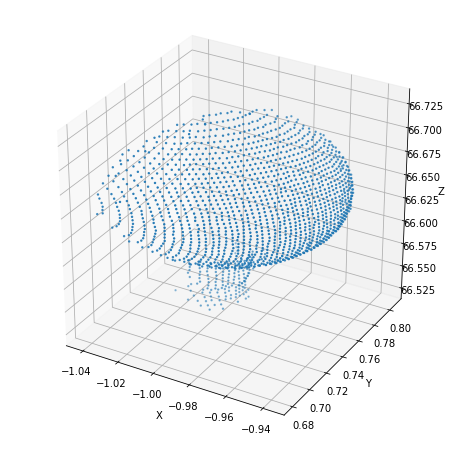

In [9]:
%matplotlib inline
import numpy as np
import sm
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

## test data (1581 points)
X1=np.loadtxt("./dat/sphere.dat")

## plot
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X1[:,0], X1[:,1], X1[:,2], s=2)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()


Now estimate best fitting sphere with RANSAC. In our case `min_samples = 4`. Value of `residual_threshold` should be neither small nor large. After trial and error the value `0.07` might seem good.

In [10]:
ransac_model, inliers = sm.ransac(X1, SphereModel, 4, 0.003)

np.set_printoptions(suppress=True)
print("parameters        : ", ransac_model.params)
print("number of points  : ", X1.shape[0])
print("number of outliers: ", X1.shape[0]-np.sum(inliers))

parameters        :  [-1.0067282   0.75263481 66.65209555  0.06952197]
number of points  :  1581
number of outliers:  156


If we repeat this calculation we get slightly different sets of parameters and number of outliers. This is due to the randomized nature of RANSAC - results depend on chance.

Plot consensus set and outliers:

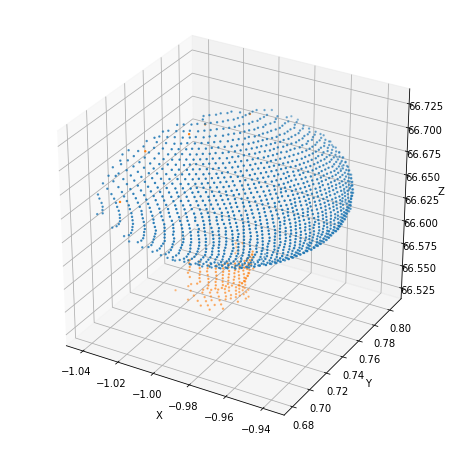

In [11]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111,  projection='3d')
ax.scatter(X1[inliers,0], X1[inliers,1], X1[inliers,2],s=2)
outliers = np.invert(inliers)
ax.scatter(X1[outliers,0], X1[outliers,1], X1[outliers,2],s=2)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

### Fit residuals
Plot histogram of residuals of conform points.

mean:    -0.00 %
std :    0.72 %
max:       5.49 %


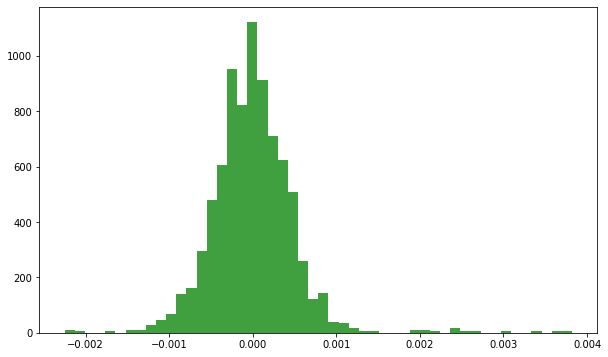

In [12]:
def sphdist(sph,X,pos=1):
    """
    sphdist(sph,X) calculate distances of points X from sphere sph
    sph: 4-element vector: [x0, y0, z0, r]
         x0, y0, z0: centre of sphere
         r: radius of sphere
    X: (n,3) matrix, coordinates of n points
    pos: if pos=0 calculate signed, otherwise unsigned deviations
    """
    r = sph[3]
    c = sph[0:3]
    # distance from centre squared
    dc = np.sum((X-c)**2,axis=1)
    if pos==1:
        dist = np.abs(np.sqrt(dc)-r)
    else:
        dist = np.sqrt(dc)-r
    return dist

# calculate signed distances (residuals)
v = sphdist(ransac_model.params,X1[inliers,:],0)

# residuals in percent relative to the radius of sphere
print("mean:  %7.2f" % (100*np.mean(v)/ransac_model.params[3]) + " %")
print("std : %7.2f" % (100*np.std(v)/ransac_model.params[3]) + " %")

# max. percent residual
print("max:    %7.2f" % (100*np.max(np.abs((v)))/ransac_model.params[3]) + " %")

# histogram of relative residuals
fig = plt.figure(figsize=(10, 6))
n, bins, patches = plt.hist(v, 50, density=True, facecolor='green', alpha=0.75)
plt.show()

### Quantile-quantile (Q-Q) plot

Check whether distribution is Gaussian by using a normal quantile-quantile plot.

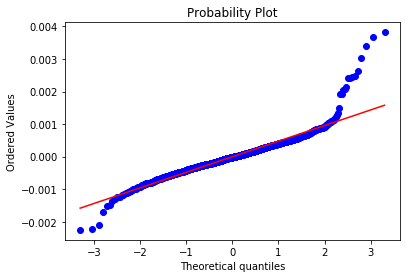

In [13]:
import scipy.stats as stats

stats.probplot(v, dist="norm", plot=plt)
plt.show()

We see that tails follow a non-Gaussian distribution.

### Additional RANSAC variants

Many flavors of RANSAC have been developed during the years. We mention M-estimation MSAC, Maximum Likelihood MLESAC, or KALMANSAC. One flavor of RANSAC searches for multiple models in the data ([Toldo és Fusiello, 2008](https://pdfs.semanticscholar.org/0455/e5596d734e3dcf60c0179efb6404e62ceabb.pdf)). In BaySAC, instead of random model selection, probability of the model is maximised upon information from prior unplausible models. 